In [1]:
import scipy.io as spio
import numpy as np

In [2]:
X = spio.loadmat(file_name='../data/bci-sample-data/x.mat')

In [3]:
Y = spio.loadmat(file_name='../data/bci-sample-data/y.mat')

In [4]:
Data = X['Intensification_Data']
SType = Y['Intensification_SType'].mean(axis=1)

In [5]:
(Data.shape, SType.shape, Data.dtype, SType.dtype)

((6480, 192, 64), (6480,), dtype('<f8'), dtype('float64'))

In [6]:
# 30 % total data test
# 70 % total data train+valid
length = int(Data.shape[0] * 0.30)
length

1944

In [7]:
TrainDataAll = Data[:-length]
TestData = Data[-length:]

In [8]:
TrainDataAll.shape, TestData.shape

((4536, 192, 64), (1944, 192, 64))

In [9]:
# 30% total train data is valid
# 70% total trainALl is training
length2 = int(TrainDataAll.shape[0] * 0.30)
length2

1360

In [10]:
TrainData = TrainDataAll[:-length2]
ValidData = TrainDataAll[-length2:]

In [11]:
TrainData.shape, ValidData.shape

((3176, 192, 64), (1360, 192, 64))

In [12]:
# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [13]:
# Standardize/normalize train and test
X_train_norm = normalize(inputs=TrainData)
X_valid_norm = normalize(inputs=ValidData)
X_test_norm = normalize(inputs=TestData)

In [14]:
(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

((3176, 192, 64),
 dtype('<f8'),
 (1360, 192, 64),
 dtype('<f8'),
 (1944, 192, 64),
 dtype('<f8'))

In [15]:
LabelsAll = SType[:]
TrainLabelsAll = SType[:-length]
TestLabels = SType[-length:]

In [16]:
LabelsAll.shape, TrainLabelsAll.shape, TestLabels.shape

((6480,), (4536,), (1944,))

In [17]:
TrainLabels = TrainLabelsAll[:-length2]
ValidLabels = TrainLabelsAll[-length2:]

In [18]:
TrainLabels.shape, ValidLabels.shape

((3176,), (1360,))

In [19]:
Y_train = np.array(TrainLabels, dtype=int)
Y_valid = np.array(ValidLabels, dtype=int)
Y_test = np.array(TestLabels, dtype=int)

In [20]:
(Y_train.shape, Y_train.dtype, 
Y_test.shape, Y_test.dtype,
Y_valid.shape, Y_valid.dtype)

((3176,), dtype('int64'), (1944,), dtype('int64'), (1360,), dtype('int64'))

### Hyperparameters

In [21]:
# CNN hyper parameters
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
n_classes = int(LabelsAll.max() + 1)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 1 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [22]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

In [23]:
(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape,
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

((3176, 2),
 (1360, 2),
 (1944, 2),
 (3176, 192, 64),
 (1360, 192, 64),
 (1944, 192, 64))

# GPUs availability or CPU

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [25]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

In [27]:
# Convolutional Layers, FC Layer, and Output layer
# # (batch, 192, 9) --> (batch, 91, 18)
# out_conv = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=12, strides=2, 
#                          padding='valid', activation = tf.nn.relu)
# out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
# print(out_conv.shape)

# # (batch, 91, 18) --> (batch, 91*18) --> (batch, 91*18*2)
# # 91 * 18 = 728 + 910 = 1638 * 2 = 3276
# # (batch, 91, 18) --> (batch, 1638) --> (batch, 3276)
# in_fc = tf.reshape(out_conv, (-1, 91*18))
# out_fc = tf.layers.dense(inputs=in_fc, units=91*18*2, activation=tf.nn.relu)
# out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
# print(in_fc.shape, out_fc.shape)

# # (batch, 91*18*2) --> (batch, 2) 
# logits = tf.layers.dense(inputs=out_fc, units=n_classes)
# print(logits.shape)

In [37]:
# Construct the LSTM inputs and LSTM cells
#  This functions very similar to embedding
print(inputs_.shape)
lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
print(lstm_in.shape)
lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
print(lstm_in.shape)

# To cells
lstm_size = n_channels*3         # 3 times the amount of channels
print(lstm_size)
lstm_layers = 1        # Number of layers
lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
print(lstm_in.shape)

# Open up the tensor into a list of seq_len pieces
lstm_in = tf.split(lstm_in, seq_len, 0)
print(len(lstm_in))

(?, 192, 64)
(192, ?, 64)
(?, 64)
192
(?, 192)
192


In [38]:
# # Construct the LSTM inputs and LSTM cells
# # To cells
# lstm_size = n_channels*3         # 3 times the amount of channels
# print(lstm_size)
# lstm_layers = 1        # Number of layers

In [39]:
# Add LSTM layers
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
print(lstm)
drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
print(drop)
cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
print(cell)
initial_state = cell.zero_state(batch_size, tf.float32)
print(initial_state)

(LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState_3/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(31, 192) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState_3/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(31, 192) dtype=float32>),)


In [40]:
# Reuse should be activated
# Remember the inputs are usually embedded input or texts
outputs, final_state = tf.contrib.rnn.static_rnn(cell=cell, inputs=lstm_in, dtype=tf.float32, 
                                                 initial_state = initial_state)
# outputs, final_state = tf.nn.dynamic_rnn(cell, lstm_in, dtype=tf.float32, 
#                                          initial_state=initial_state)# print(outputs, final_state)

In [41]:
# We only need the last output tensor to pass into a classifier
logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
print(logits, outputs[-1])

Tensor("logits/BiasAdd:0", shape=(31, 2), dtype=float32) Tensor("rnn_3/rnn/multi_rnn_cell/cell_0_191/dropout/mul:0", shape=(31, 192), dtype=float32)


In [42]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [48]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_: keep_prob, initial_state:state, 
                    learning_rate_:learning_rate}
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Initiate for validation set
            val_state = sess.run(cell.zero_state(batch_size, tf.float32))

            val_acc_ = []
            val_loss_ = []

            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictiobary of valid minibatches
                feed = {inputs_:x_v, labels_:y_v, keep_prob_:1.0, initial_state:val_state}

                # Loss
                loss_v, val_state, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                # loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)

                val_acc_.append(acc_v)
                val_loss_.append(loss_v)

            # Print info
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(loss),
                  "Validation loss: {:6f}".format(np.mean(val_loss_)),
                  "Train acc: {:.6f}".format(acc),
                  "Validation acc: {:.6f}".format(np.mean(val_acc_)))

            # Store
            validation_acc.append(np.mean(val_acc_))
            validation_loss.append(np.mean(val_loss_))

Epoch: 1/1 Train loss: 0.729235 Validation loss: 0.741735 Train acc: 0.612903 Validation acc: 0.524381
Epoch: 1/1 Train loss: 0.615117 Validation loss: 0.740116 Train acc: 0.741935 Validation acc: 0.546136
Epoch: 1/1 Train loss: 0.580960 Validation loss: 0.721459 Train acc: 0.806452 Validation acc: 0.553638
Epoch: 1/1 Train loss: 0.432633 Validation loss: 0.720844 Train acc: 0.870968 Validation acc: 0.552138
Epoch: 1/1 Train loss: 0.583333 Validation loss: 0.721707 Train acc: 0.806452 Validation acc: 0.552888
Epoch: 1/1 Train loss: 0.568717 Validation loss: 0.673426 Train acc: 0.741935 Validation acc: 0.583646
Epoch: 1/1 Train loss: 0.603415 Validation loss: 0.625383 Train acc: 0.645161 Validation acc: 0.648162
Epoch: 1/1 Train loss: 0.463846 Validation loss: 0.598205 Train acc: 0.774194 Validation acc: 0.694674
Epoch: 1/1 Train loss: 0.517157 Validation loss: 0.586475 Train acc: 0.838710 Validation acc: 0.708927
Epoch: 1/1 Train loss: 0.547511 Validation loss: 0.578707 Train acc: 0.83

Epoch: 1/1 Train loss: 0.565825 Validation loss: 0.456541 Train acc: 0.806452 Validation acc: 0.833458
Epoch: 1/1 Train loss: 0.564909 Validation loss: 0.456732 Train acc: 0.774194 Validation acc: 0.833458
Epoch: 1/1 Train loss: 0.479041 Validation loss: 0.457484 Train acc: 0.838710 Validation acc: 0.833458
Epoch: 1/1 Train loss: 0.429094 Validation loss: 0.458788 Train acc: 0.838710 Validation acc: 0.833458
Epoch: 1/1 Train loss: 0.404151 Validation loss: 0.461374 Train acc: 0.838710 Validation acc: 0.833458
Epoch: 1/1 Train loss: 0.605953 Validation loss: 0.461968 Train acc: 0.741935 Validation acc: 0.833458
Epoch: 1/1 Train loss: 0.523092 Validation loss: 0.463016 Train acc: 0.774194 Validation acc: 0.833458
Epoch: 1/1 Train loss: 0.515139 Validation loss: 0.462276 Train acc: 0.806452 Validation acc: 0.833458
Epoch: 1/1 Train loss: 0.429008 Validation loss: 0.462441 Train acc: 0.838710 Validation acc: 0.833458
Epoch: 1/1 Train loss: 0.454095 Validation loss: 0.461983 Train acc: 0.83

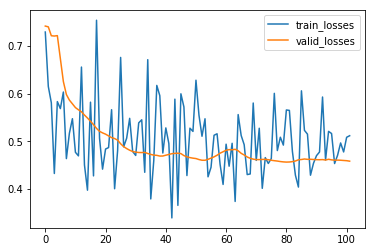

In [49]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_losses')
mplot.plot(validation_loss, label='valid_losses')
mplot.legend()
mplot.show()

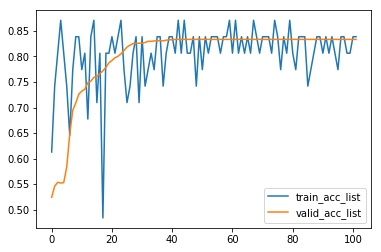

In [50]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc_list')
mplot.plot(validation_acc, label='valid_acc_list')
mplot.legend()
mplot.show()